In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.59
transformers version : 2.2.1


In [3]:
DATA_ROOT = Path("bro/")
train = pd.read_csv(DATA_ROOT / 'ulm_train.csv')
test = pd.read_csv(DATA_ROOT / 'ulm_test.csv')
print(train.shape,test.shape)
train.head()

(1800, 3) (300, 3)


,label,text,is_valid
0,fe,সাম্প্রদায়িক সংঘাত ও মানবিক প্রতিরোধ সাম্প্রদা...,False
1,ij,আজ মাও সেতুং-এর জন্মদিন। মাও সে তুং। বারবার ইত...,False
2,mk,"গোলাম আযমের বিরুদ্ধে অভিযোগ ৬১ টি, যেকোনো ১ টি...",False
3,rn,জলের সন্তরন- (এক) অনেক গুলো সাপ মিজানের শরীরের...,False
4,hm,খুবরগুড়ে . . . এইভাবে হতে থাকে ক্রমাগত কেউ মার...,False


In [4]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [5]:
# Parameters
seed = 42
use_fp16 = False
bs = 6

model_type = 'bert'
pretrained_model_name = 'bert-base-multilingual-cased' # 'roberta-base-openai-detector'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [6]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [7]:
# model_class.pretrained_model_archive_map.keys()

### Util function

Function to set the seed for generating random numbers.

In [8]:
torch.cuda.is_available()

True

In [9]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [10]:
seed_all(seed)

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [12]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [13]:
# tokenizer_class.pretrained_vocab_files_map

In [14]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [15]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [18]:
'okay'

'okay'

Check batch and tokenizer :

In [19]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
"[CLS] পান ##শা ##লা ০ ##০২ পান ##শা ##লা শ ##ির ##োন ##াম ##ের এক ##টা স ##ির ##িজ ল ##ে ##খা শুরু করে ##ছিল ##াম অনেক আগে । শ ##ি ##ব ##্রাম চ ##ক ##র ##ব ##রত ##ি আ ##মার অনেক মা ##ন ##স ##গ ##ুর ##ু ##দের একজন , তা ##ই পান ##প ##্রে ##মিক কিছু চ ##রি ##ত্র ##ের ম ##ু ##খে P ##UN গ ##ু ##ঁ",hm
"[CLS] জ ##ঙ্গ ##ি দ ##ম ##নে স ##া ##ফ ##ল ##্য ও [UNK] বাংলাদেশের স ##মা ##জে ##র অ ##ভ ##্য ##ন্ত ##রে জ ##ঙ্গ ##ি ##বাদ যে গ ##ভ ##ীর [UNK] গ ##্রে ##া ##থ ##িত করেছে , তা আ ##জ আর বলা ##র অ ##পে ##ক্ষা র ##া ##খে না । গ ##ত দুই দ ##শ ##ক ধরে আ ##ম ##রা জ ##ঙ্গ ##ি ##বাদ ##ের ব",mk
"[CLS] জ ##াগ ##্র ##ত প ##্র ##জন ##্ ##ম চ ##ত্ব ##র , চ ##লো চ ##লো , শ ##াহ ##বা ##গ চ ##লো । । র ##ে ##জা ঘ ##ট ##ক শ ##িশ ##ুর ম ##ু ##খে , শ ##াহ ##বা ##গ । [UNK] ম ##ু ##খে , শ ##াহ ##বা ##গ । ব ##োন ##ের ম ##ু ##খে , শ ##াহ ##বা ##গ । [UNK] ম ##ু",rg
"[CLS] [UNK] ত ##ো ##মার ##ে [UNK] দ ##ে ##খ ##িতে , [UNK] [UNK] [UNK] _ _ _ ( পর ##্ব - চ ##ার ) [UNK] আ ##হ ##মে ##দের ন ##িন ##্দু ##কের ##া বলে ##ন , [UNK] আ ##হ ##মে ##দ হ ##ি ##ম ##ু চ ##রি ##ত্র ##টি স ##ু ##ব ##ো ##ধ ঘ ##ো ##ষে ##র ' শ ##ুন ব ##র ##নার ##ী ' উ ##পন",rn
[CLS] [UNK] গ ##ন ##হ ##ত ##্যা _ খ ##ে ##মার র ##ু ##জ শ ##াস ##নের এক [UNK] [UNK] । ছোট ##্ট এই [UNK] খ ##ে ##মার র ##ু ##জ গ ##ের ##িলা ##রা র ##ে ##হ ##াই [UNK] । র ##ু ##জ শ ##ব ##্দ ##টা ফ ##রা ##স ##ী ; অর্থ ল ##াল । কাজ ##েই খ ##ে ##মার র ##ু ##জ শ ##ব ##্দ ##ের অর্থ,ij


In [20]:
databunch.train_dl.dl.dataset[0][0].text

'[CLS] [UNK] স ##ং ##ঘ ##াত ও মা ##ন ##বি ##ক প্রতি ##র ##ো ##ধ [UNK] স ##ং ##ঘ ##াত ও মা ##ন ##বি ##ক প্রতি ##র ##ো ##ধ ##ফ ##কি ##র [UNK] = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = আ ##মি যে দেশ ##টি ##তে থ ##াক ##ি এখানে ব ##হ ##ু ##জা ##তি ##ক , ব ##হ ##ু ##ভা ##ষ ##িক মানুষের বা ##স । অনেক ধ ##র্ম ##াব ##ল ##ম ##্ব ##ী , মত ##াব ##ল ##ম ##্ব ##ী মানু ##ষ । ক ##ার ##ো সঙ্গে ক ##ার ##ো কোনো ম ##িল ন ##েই । এর ##া চ ##াই ##লে কিন্তু খুব স ##াম ##ান ##্য [UNK] [UNK] প্রতি ##দিন দ ##া ##ঙ্গ ##া করতে প ##ার ##ত ##ো । না - ত ##ে ##ম ##ন ##টি এখানে হচ্ছে না । হ ##্যা ##ঁ , [UNK] প ##া ##ঠ ##ক - আ ##মি মার্কিন য ##ুক্ত ##রাষ্ট্র ##ের কথা ব ##ল ##ছ ##ি । এটি এমন একটি দেশ , মানু ##ষ মানুষের ব ##ুক ##ের প ##া ##ঁ ##জ ##র [UNK] [UNK] ফ ##েল ##ত ##ো ! য ##দি এ দেশ ##ে ক ##ঠ ##োর আ ##ইন না থ ##াক ##ত ##ো । না - তারা তা প ##ার ##ছে না । প ##ার ##বে না । প ##ার ##বে না এ জন্য , এমন কিছু ক ##র ##লে তাদের ক ##ঠ ##িন শ ##াস ##্তি ##র ম ##ু ##খ ##ো ##ম ##ু ##খ ##ি হত

## Check `wordpiece` for non-latin(bangla)

Check batch and numericalizer :

In [21]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([6, 512])
tensor([[  101,   938, 37376,  ..., 11737, 66199,   102],
        [  101,   958, 11199,  ..., 12079, 53372,   102],
        [  101,   100,   978,  ...,   100,   974,   102],
        [  101,   948, 12235,  ...,   100,   100,   102],
        [  101,   100,   968,  ...,   117,   938,   102],
        [  101,   968, 22756,  ..., 26788, 19910,   102]])


In [22]:
numtest = test_one_batch[0][:100]
numtest

tensor([   101,    938,  37376,  11737,  29261,    974,  26145,  29454,    972,
         69514,  30277,  11421,    978,  29806,  74501,  17511, 111238,  11128,
        111240, 111228,  15215,    954,  47356,    112,  59136,  11128,  16431,
         56251,    112,    168,    976,  19668,  19910,  72614,  27608,    938,
         22875, 111240,  39427,  11128,  15215,    100,    970,  45908,  45947,
         11421,    937,  11737,  70115,  29740,  12235,  56251,  12235,    920,
           920,    938,  24383,  14339,    959,  15691,  28777,  22875,  16431,
         28777,  32465,  93915,  45002,  23538,  20699,  21398,  59038,  25017,
           100,    973,  16166,  19910,  28410,  24383,  46085, 111240,  39427,
         38044,  99475,  13104,    969,  21790,  12079, 111231, 111240,  39427,
           969,  15010,  32359,  39994,  79959,    946,  16869,    978,  85040,
           968])

In [23]:
numtest[:10].tolist()

[101, 938, 37376, 11737, 29261, 974, 26145, 29454, 972, 69514]

In [24]:
# "vocab_size": 119547
transformer_tokenizer.decode(numtest.tolist())

"[CLS] আমিনুর রহমান মুকুলের স্বল্পদৈর্ঘ্য ছবি'অবরোধ'_ শতাব্দীর আশ্চর্য [UNK] বৃত্তের অনন্ত পরিধি । । আজ থেকে ঠিক একশো এক বছর আগে ১৯১৪ সালের ২৮ জুন [UNK] যুবরাজ আর্চডিউক ফ্রাঞ্চ ফার্ডিন্যান্ড ও তার স্ত্রী প"

In [25]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
                
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [26]:
databunch.train_dl.classes

['fe', 'hm', 'ij', 'mk', 'rg', 'rn']

In [27]:
labels = len(databunch.train_dl.classes)
labels

6

In [28]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = labels
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 6,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 119547
}



In [29]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [30]:
use_fp16

False

In [31]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input,correct_bias=False), 
                  metrics=[accuracy])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [32]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

(same for bert)
In this case, we can split our model in this way :

In [33]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For bert-base
list_layers = [learner.model.transformer.bert.embeddings,
              learner.model.transformer.bert.encoder.layer[0],
              learner.model.transformer.bert.encoder.layer[1],
              learner.model.transformer.bert.encoder.layer[2],
              learner.model.transformer.bert.encoder.layer[3],
              learner.model.transformer.bert.encoder.layer[4],
              learner.model.transformer.bert.encoder.layer[5],
              learner.model.transformer.bert.encoder.layer[6],
              learner.model.transformer.bert.encoder.layer[7],
              learner.model.transformer.bert.encoder.layer[8],
              learner.model.transformer.bert.encoder.layer[9],
              learner.model.transformer.bert.encoder.layer[10],
              learner.model.transformer.bert.encoder.layer[11],
              learner.model.transformer.bert.pooler]

Check groups : 

In [34]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 14 groups
[Sequential(
  (0): Embedding(119547, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fe

### Train
Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [35]:
learner.save('untrain')

In [36]:
seed_all(seed)
learner.load('untrain');

Therefore, we first freeze all the groups but the classifier with :

In [37]:
learner.freeze_to(-1)

We check which layer are trainable

In [38]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           91,812,096 False     
______________________________________________________________________
Embedding            [512, 768]           393,216    False     
______________________________________________________________________
Embedding            [512, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

For **Slanted Triangular Learning Rates** you have to use the function ``one_cycle``. For more information please check the fastai documentation [here](https://docs.fast.ai/callbacks.one_cycle.html). 

To use our ``one_cycle`` we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using ``lr_find``.

In [39]:
learner.lr_find()

epoch     train_loss  valid_loss  accuracy  time    
0         8.440509    #na#        00:10     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-04
Min loss divided by 10: 4.37E-06


/home/student_1/.local/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


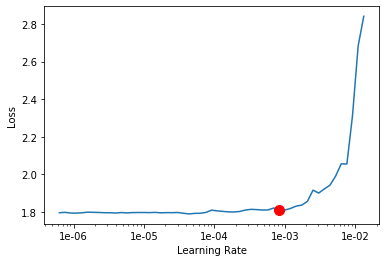

In [40]:
learner.recorder.plot(skip_end=7,suggestion=True)

Min numerical gradient: 8.32E-04
Min loss divided by 10: 4.37E-06


/home/student_1/.local/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


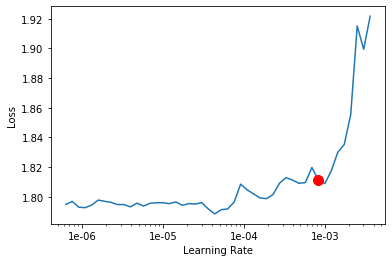

In [41]:
learner.recorder.plot(skip_end=14,suggestion=True)

In [42]:
lr = learner.recorder.min_grad_lr
lr

0.0008317637711026709

We will pick a value a bit before the minimum, where the loss still improves.
Next we will use ``fit_one_cycle`` with the chosen learning rate as the maximum learning rate. 

In [43]:
learner.fit_one_cycle(5,max_lr=lr,moms=(0.8,0.7))

epoch     train_loss  valid_loss  accuracy  time    
0         1.440972    1.213701    0.566667  00:39     
1         1.321238    1.096493    0.538889  00:39     
2         1.052915    1.027263    0.572222  00:39     
3         0.800315    0.763710    0.716667  00:39     
4         0.738587    0.670436    0.761111  00:39     


In [44]:
learner.save('fifth_cycle')

### Lets see how far pretrained multilingual bert can go

In [45]:
# learner.fit_one_cycle(10,max_lr=1e-03,moms=(0.8,0.7))

In [46]:
# learner.fit_one_cycle(10,max_lr=1e-03,moms=(0.8,0.7))

--> Looks like oscillation!

In [47]:
seed_all(seed)
learner.load('fifth_cycle');

We then unfreeze the second group of layers and repeat the operations.

In [48]:
learner.freeze_to(-2)

epoch     train_loss  valid_loss  accuracy  time    
0         2.076243    #na#        00:09     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 4.37E-06


/home/student_1/.local/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


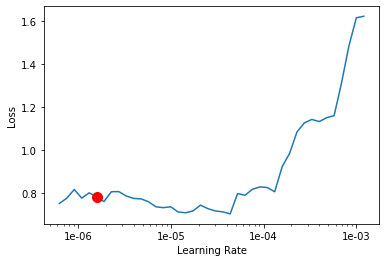

In [49]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

In [50]:
lr = learner.recorder.min_grad_lr
lr

1.5848931924611132e-06

Note here that we use slice to create separate learning rate for each group.

In [51]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch     train_loss  valid_loss  accuracy  time    
0         0.717063    0.649820    0.777778  00:44     
1         0.653574    0.632761    0.783333  00:44     


In [52]:
learner.save('seventh_cycle')

In [53]:
seed_all(seed)
learner.load('seventh_cycle');

In [54]:
learner.freeze_to(-3)

In [55]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch     train_loss  valid_loss  accuracy  time    
0         0.654547    0.560868    0.811111  00:49     
1         0.565911    0.524572    0.811111  00:49     


In [56]:
learner.save('nineth_cycle')

In [57]:
seed_all(seed)
learner.load('nineth_cycle');

Here, we unfreeze all the groups.

In [58]:
learner.unfreeze()

In [59]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch     train_loss  valid_loss  accuracy  time    
0         0.464625    0.432993    0.816667  01:51     
1         0.350756    0.335737    0.872222  01:51     


In [60]:
learner.save('eleventh_cycle')

In [62]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('16th_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.248207    0.362638    0.844444  01:48     
1         0.324291    0.309610    0.883333  01:48     
2         0.236128    0.282102    0.888889  01:48     
3         0.163207    0.265682    0.888889  01:48     
4         0.144963    0.237124    0.894444  01:48     


In [63]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('21st_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.127669    0.251709    0.888889  01:48     
1         0.146631    0.207671    0.922222  01:48     
2         0.120595    0.225826    0.922222  01:48     
3         0.073617    0.197451    0.922222  01:49     
4         0.075474    0.203804    0.927778  01:48     


In [64]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('26th_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.076217    0.203757    0.911111  01:47     
1         0.099439    0.191921    0.922222  01:48     
2         0.060514    0.224196    0.916667  01:48     
3         0.038200    0.184359    0.944444  01:48     
4         0.035232    0.176545    0.944444  01:48     


In [65]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('30th_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.048777    0.168789    0.950000  01:48     
1         0.041498    0.182499    0.955556  01:48     
2         0.045916    0.182129    0.955556  01:48     
3         0.028575    0.182004    0.955556  01:48     
4         0.029860    0.181737    0.955556  01:48     


In [66]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('35th_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.040757    0.199297    0.927778  01:49     
1         0.024647    0.174629    0.950000  01:48     
2         0.018106    0.169789    0.950000  01:48     
3         0.011312    0.172013    0.950000  01:48     
4         0.012961    0.183215    0.950000  01:48     


### Creating prediction
Now that the model is trained, we want to generate predictions from the test dataset.

In [67]:
def testing(df):
    text_array = df["text"].tolist()
    print(len(text_array))

    final_preds = []

    for text in text_array:
      preds = learner.predict(text)
      final_preds.append(str(preds[0]))

    targets = df["label"].tolist()

    err=[]
    count =0;
    tst = len(text_array)

    for i in range(tst):
        if(targets[i]==final_preds[i]):
          count = count+1
        else:
          err.append((targets[i],final_preds[i]))
    print("Accuracy: ")
    print(count/tst)
    print(err)

    return final_preds,targets

In [68]:
pred,targ = testing(test)

300
Accuracy: 
0.9333333333333333
[('ij', 'rn'), ('rg', 'rn'), ('rn', 'mk'), ('ij', 'rn'), ('mk', 'rn'), ('mk', 'rg'), ('rg', 'ij'), ('ij', 'rg'), ('hm', 'mk'), ('ij', 'rn'), ('mk', 'rg'), ('mk', 'rg'), ('mk', 'hm'), ('fe', 'rn'), ('ij', 'rn'), ('mk', 'rg'), ('hm', 'mk'), ('rg', 'mk'), ('rn', 'mk'), ('rn', 'rg')]


This NoteBook combines the ``transformers`` library with ``fastai`` library. It allows us to use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and even **Gradual Unfreezing**.

## References
* Hugging Face, Transformers GitHub (Nov 2019), [https://github.com/huggingface/transformers](https://github.com/huggingface/transformers)
* Fast.ai, Fastai documentation (Nov 2019), [https://docs.fast.ai/text.html](https://docs.fast.ai/text.html)
* Jeremy Howard & Sebastian Ruder, Universal Language Model Fine-tuning for Text Classification (May 2018), [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)
* Keita Kurita's article : [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (May 2019)
* Dev Sharma's article : [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Sep 2019)